## Assignment 3.2 (N1 and all road segments visualization)

## Instruction to use this program

 - This code need to have _roads3.csv and its BMMS_overview.xlsx files from the "WBSIM_Lab2"
 
 
 - It also need RMMS folder which contains the traffic.html data and width.processed.txt data for each roads
 
 
 - Change the path of the first cell before running the code!!!!!
 
 
 - The last two cells that provided here are the two different way to plot the road segment : 
 
     - The first last cell were provided to user to plot the road segments by changing the code slightly (editing the cells) 
 
     - The second last cell were provided to give user easy access for plotting the road segments without changing the line of code (by user defined input) and it is case insensitive
     
     - To switch them, comment and uncomment one of the cell
 
 
 - The code will plot the result as interactive map in HTML formats which user can click on the roads and bridges to know the detailed information for that particular road segments
 
 
 - Color defined as a vulnerability of roads or bridges, while the size of the road colour determine the criticality of the roads, bigger size of the road, means it is more critical, the darker the color, means less vulnerable and vice versa
 
 
 - There are 14 different colour representation for the vulnerability
 
 
 - User can choose which bridge to plot in the map by check or uncheck the bridges control button (below the vulnerability score legend) and can click on the roads or bridges to know their detailed information

## Assumption

- The combined dataframe that produced by function "import_data" is not preprocessed yet, the code just combine the whole data for each roads therefore there are a lot of NaN values inside the dataframe since our preprocessing scripts rely heavily on the order of chainage and every roads start their chainage at 0, therefore we need to select the road first to do preprocessing


- The preprocessing part was done by function "plot_map", this include filling the NaN values as well as determine the vulnerability and critically score for each road and bridge segments since the data that want to be plotted already selected by the user at this stage


- Since the criticality score have high values and it is correspond to the width of the polyline in the roads visualization, all values then divided by 500 to reduced the size of the visualization of the road segments


- We assume that the vulnerability of the roads follow the bridge quality in the nearest bridge to that particular road, so we fill in the quality of the roads dependant on nearest bridge with function called (bfill)

In [1]:
#!pip install folium
#!pip install ipywidgets
#!pip install pdvega

import folium
from folium import plugins
from folium.map import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import json
import webbrowser

import math

# path of road data for reading csv file (_roads3)
road_path     = 'D:\Jupyter_File\Advanced_Discrete_Cleaning\WBSIM_Lab2\infrastructure\_roads3.csv'

# path of bridge data for reading Excel file (BMMS_overview)
bridge_path     = 'D:\Jupyter_File\Advanced_Discrete_Cleaning\WBSIM_Lab2\infrastructure\BMMS_overview.xlsx'

# folder path of html traffic data and width.processed txt files 
path  = 'D:\Jupyter_File\Advanced_Discrete_Cleaning\RMMS' # path to RMMS

## Function to import 4 datasets and combine them into one dataframe

In [2]:
def import_data(road_path,bridge_path,path):    
    
    # read _roads3.csv datafile  
    df_orig  = pd.read_csv(road_path,index_col=None, header=0)
    
    # read BMMS_overview.xlsx datafile 
    bdf_orig = pd.read_excel(bridge_path, index_col=None, header=0)
    
    # Create blank column for roads dataframe to match with the bridge dataframe format 
    df_orig['width'] = np.nan
    df_orig['Length'] = np.nan
    df_orig['Quality'] = np.nan
    df_orig['LinkName'] = np.nan
    df_orig['constructionYear'] = np.nan

    # Mark which data is from which source (BMMS_overview or _roads3)
    df_orig['Data_source'] = 'road3' #_roads3.csv source
    bdf_orig['Data_source'] = 'BMMS'  #BMMS_overview.xlsx source

    # drop unnecessary column that is not needed in the construction of excel files
    df_orig = df_orig.drop(['gap'], axis=1)
    bdf_orig = bdf_orig.drop(['km', 'structureNr', 'spans', 
                                      'zone','circle','division',
                                      'sub-division', 'EstimatedLoc'], axis=1)

    # Script to drop "Bridges" included in the roads data
    df_orig = df_orig.drop(df_orig[df_orig['type'] == 'Bridge'].index)

    # Rename some columns names to match with the roads dataframe
    bdf_orig = bdf_orig.rename(index=str, columns={'LRPName': 'lrp' ,'condition':'Quality',
                                                           'length':'Length', 'roadName':'LinkName'})

    # Combined roads and bridges data
    df1_combined = pd.concat([df_orig, bdf_orig])
    
    # Creating intial dataframe for the 2 datasets (width.processed.txt and html traffic data) with N1 as the initial
    rname0 = 'N1'
    # Reading raw intial text files for width
    textPath = path + '\\' + rname0 + '.widths.processed.txt' # define the path
    width_data0      = pd.read_table(textPath) #reading the txt files based on the path
    
    # Marking the datasource of width.processed.txt
    width_data0['Data_source'] = 'widths'

    # Reading raw initial html (N1)
    htmlPath = path + '\\' + rname0 + ".traffic.htm"
    
    # Read the raw html files and choose only table data from the html files which in the fourth structure
    rawHtml0  = pd.read_html(htmlPath)[4]
    
    # Change some variables columns names in html file, number is used, since there are duplicates column name
    rawHtml0.loc[2,0] = 'LinkNo'
    rawHtml0.loc[2,1] = 'LinkName'
    rawHtml0.loc[2,4] = 'ChainageS'
    # later on the when combining the whole dataframe, we only select end of chainage as the representative of the data 
    # since there are start and end chainage that have the same data
    rawHtml0.loc[2,7] = 'chainage'

    # select only table information
    html_data0         = rawHtml0.loc[3:len(rawHtml0),:] 

    # change column name and create some blank columns to match with other dataframe
    html_data0.columns = rawHtml0.loc[2,:]
    html_data0 = html_data0.reset_index(drop=True)
    html_data0['width'] = np.nan
    html_data0['nrLanes'] = np.nan
    html_data0['Data_source'] = 'html'
    html_data0 = html_data0.rename(index=str, columns={"(Km)": "Distance", "(AADT)": "AADT"})
    html_data0 = html_data0.drop('Total AADT', axis=1)
    html_data0.columns.values[0] = 'road'
    html_data0.columns.values[2] = 'LRPStart'
    html_data0.columns.values[3] = 'OffsetStart'
    html_data0.columns.values[5] = 'lrp'
    html_data0.columns.values[6] = 'OffsetEnd'
    
    # function to sum left and right lanes traffic for initial 
    html_data0 = html_data0.apply(pd.to_numeric,errors='ignore').sort_values(by='chainage') # convert data to numeric from strings
    for i in range(len(html_data0)-1):
        if (html_data0.iloc[i,7]) == (html_data0.iloc[i+1,7]):
            for j in range(9,len(html_data0.columns)-1):
                html_data0.iloc[i,j] = (html_data0.iloc[i,j]) + (html_data0.iloc[i+1,j])
    # drop the left and right lanes in the html data
    html_data0 = html_data0.drop_duplicates(subset='chainage',keep='first').reset_index(drop=True)
    
    # create the blank list for listing road segment that is not found un the RMMS folder
    notfound = []
    
    # the same operation as the initial 4 dataset export but the other dataset
    for i in range (1,len(bdf_orig.road.value_counts().index)):
        rname = bdf_orig.road.value_counts().index[i]
        try:
            textPath = path + '\\' + rname + '.widths.processed.txt'
            width_data      = pd.read_table(textPath)
            width_data['Data_source'] = 'widths'

            # reading raw html
            htmlPath = path + '\\' + rname + ".traffic.htm"
            rawHtml  = pd.read_html(htmlPath)[4]

            rawHtml.loc[2,0] = 'LinkNo'
            rawHtml.loc[2,1] = 'LinkName'
            rawHtml.loc[2,4] = 'ChainageS'
            rawHtml.loc[2,7] = 'chainage'

            # select only table information
            html_data         = rawHtml.loc[3:len(rawHtml),:] 

            # change column name
            html_data.columns = rawHtml.loc[2,:]
            html_data = html_data.reset_index(drop=True)
            html_data['width'] = np.nan
            html_data['nrLanes'] = np.nan
            html_data['Data_source'] = 'html'
            html_data = html_data.rename(index=str, columns={"(Km)": "Distance", "(AADT)": "AADT"})
            html_data = html_data.drop('Total AADT', axis=1)
            html_data.columns.values[0] = 'road'
            html_data.columns.values[2] = 'LRPStart'
            html_data.columns.values[3] = 'OffsetStart'
            html_data.columns.values[5] = 'lrp'
            html_data.columns.values[6] = 'OffsetEnd'
            
            html_data = html_data.apply(pd.to_numeric,errors='ignore').sort_values(by='chainage')
            for a in range(len(html_data)-1):
                if (html_data.iloc[a,7]) == (html_data.iloc[a+1,7]):
                    for b in range(9,len(html_data.columns)-1):
                        html_data.iloc[a,b] = (html_data.iloc[a,b]) + (html_data.iloc[a+1,b])

            html_data = html_data.drop_duplicates(subset='chainage',keep='first').reset_index(drop=True)
            
            width_data0  = pd.concat([width_data0, width_data])
            html_data0  = pd.concat([html_data0, html_data])
            
        except:
            notfound.append(bdf_orig.road.value_counts().index[i])
    
    # deleting character name after "-" character to the data
    html_data0['road'] = html_data0['road'].apply(lambda x: x[:x.rfind("-")])
    
    # Rename some columns for combined width text files while deleting unimportant columns
    width_data0 = width_data0.rename(index=str, columns={"roadNo": "road", "endChainage": "chainage"})
    width_data0 = width_data0[['road','chainage','width','nrLanes','Data_source']]
    
    # oredering and selecting important column for combined html files
    html_data0 = html_data0[['Data_source','road','chainage','lrp','Heavy Truck', 'Medium Truck',
                             'Small Truck', 'Large Bus', 'Medium Bus', 'Micro Bus', 'Utility', 'Car',
                             'Auto Rickshaw', 'Motor Cycle', 'Bi-Cycle', 'Cycle Rickshaw', 'Cart',
                             'Motorized', 'Non Motorized', 'AADT', 'width', 'nrLanes']]
    
    # combine all datasets
    df1_universal = pd.concat([df1_combined, width_data0])
    df1_universal = pd.concat([df1_universal, html_data0])
    df1_universal = df1_universal.apply(pd.to_numeric,errors='ignore')
    
    return df1_combined, notfound,df1_universal, html_data0, width_data0


## Function to plot the map and preprocess the data

In [3]:
def plot_map(list_of_rname,df1_combined):

    # Load map centered of bangladesh
    my_map = folium.Map(location=[df1_combined.lat.median(), df1_combined.lon.median()], zoom_start=10)
    # Make a legend for vulnerability score color
    linear = folium.LinearColormap(['green','yellow','red'], vmin=1, vmax=14, caption = 'Vulnerability Score')
    my_map.add_child(linear)
    
    feature_group_bridges_a = folium.map.FeatureGroup(name='Bridges A')
    feature_group_bridges_b = folium.map.FeatureGroup(name='Bridges B')
    feature_group_bridges_c = folium.map.FeatureGroup(name='Bridges C')
    feature_group_bridges_d = folium.map.FeatureGroup(name='Bridges D')
    
    # iterating through road segments input
    for rname in list_of_rname :
        # selecting only the single road segment inputed from the combined version of the dataframe 
        # and sort them by chainage
        df1_combined_0 = df1_combined[(df1_combined['road'] == rname)].reset_index(drop=True).sort_values(by = 'chainage')
        
        # fill all NaN values with the next nearest datasets avaliable 
        df1_combined_0 = df1_combined_0.fillna(method='bfill').fillna(method='ffill')
        
        # drop duplicates based on chainage
        df1_combined_0 = df1_combined_0.drop_duplicates(subset = ['chainage'], keep = 'first', inplace=False)
        df1_combined_0 = df1_combined_0.sort_values(by = 'chainage').reset_index(drop = True)
        df1_combined_0['traffic_truck_crit_index'] = np.nan
        df1_combined_0['road_vul_index'] = np.nan
        
        # Fuction to create new columns name for vulnerability and criticality score
        for i in range(len(df1_combined_0)):
            # create column for criticality score and fill them for each road segments based on our definition
            df1_combined_0.loc[i,'traffic_truck_crit_index'] = (1.5*df1_combined_0['Heavy Truck'][i] 
                                                  + 1.2*df1_combined_0['Medium Truck'][i] 
                                                  + df1_combined_0['Small Truck'][i])
            
            # create column for vulnerability score and fill them for each road segments based on our definition
            if df1_combined_0['Quality'][i]=='A':
                if df1_combined_0['Length'][i]<=50:
                    df1_combined_0.loc[i,'road_vul_index'] = 1.25
                elif df1_combined_0['Length'][i]>50 and df1_combined_0['Length'][i]<=100:
                    df1_combined_0.loc[i,'road_vul_index'] = 1.5
                elif df1_combined_0['Length'][i]>100 and df1_combined_0['Length'][i]<=200:
                    df1_combined_0.loc[i,'road_vul_index'] = 1.75
                elif df1_combined_0['Length'][i]>200:
                    df1_combined_0.loc[i,'road_vul_index'] = 2
                else:
                    df1_combined_0.loc[i,'road_vul_index'] = 1

            elif df1_combined_0['Quality'][i]=='B':
                if df1_combined_0['Length'][i]<=50:
                    df1_combined_0.loc[i,'road_vul_index'] = 3.5
                elif df1_combined_0['Length'][i]>50 and df1_combined_0['Length'][i]<=100:
                    df1_combined_0.loc[i,'road_vul_index'] = 4
                elif df1_combined_0['Length'][i]>100 and df1_combined_0['Length'][i]<=200:
                    df1_combined_0.loc[i,'road_vul_index'] = 4.5
                elif df1_combined_0['Length'][i]>200:
                    df1_combined_0.loc[i,'road_vul_index'] = 5
                else:
                    df1_combined_0.loc[i,'road_vul_index'] = 3

            elif df1_combined_0['Quality'][i]=='C':
                if df1_combined_0['Length'][i]<=50:
                    df1_combined_0.loc[i,'road_vul_index'] = 6.75
                elif df1_combined_0['Length'][i]>50 and df1_combined_0['Length'][i]<=100:
                    df1_combined_0.loc[i,'road_vul_index'] = 7.5
                elif df1_combined_0['Length'][i]>100 and df1_combined_0['Length'][i]<=200:
                    df1_combined_0.loc[i,'road_vul_index'] = 8.25
                elif df1_combined_0['Length'][i]>200:
                    df1_combined_0.loc[i,'road_vul_index'] = 9
                else:
                    df1_combined_0.loc[i,'road_vul_index'] = 6

            elif df1_combined_0['Quality'][i]=='D':
                if df1_combined_0['Length'][i]<=50:
                    df1_combined_0.loc[i,'road_vul_index'] = 11
                elif df1_combined_0['Length'][i]>50 and df1_combined_0['Length'][i]<=100:
                    df1_combined_0.loc[i,'road_vul_index'] = 12
                elif df1_combined_0['Length'][i]>100 and df1_combined_0['Length'][i]<=200:
                    df1_combined_0.loc[i,'road_vul_index'] = 13
                elif df1_combined_0['Length'][i]>200:
                    df1_combined_0.loc[i,'road_vul_index'] = 14
                else:
                    df1_combined_0.loc[i,'road_vul_index'] = 10  
        
        # Create a road line one by one by its lattitude and longitude
        for i in range(len(df1_combined_0)-1):
            # blanks list of coordinates
            points = []
            # insert two coordinates to connect the line of road segments
            points.append(tuple([df1_combined_0.lat[i], df1_combined_0.lon[i]]))
            points.append(tuple([df1_combined_0.lat[i+1], df1_combined_0.lon[i+1]]))
            # create a detailed information for each road segments using html format
            testa = folium.Html(
                                """<h3>""" + rname +""" - """+  df1_combined_0.lrp[i] + """</h3><hr><br>""" +
                                
                                """ Route : """ + str(df1_combined_0.LinkName[i]) +
                                """<br>""" +
                                """Type of structure : """ + str(df1_combined_0.type[i]) +
                                """<br>""" +
                                """Construction year : """ + str(df1_combined_0.constructionYear[i]) +
                                """<br>""" +
                
                                """<hr><h4>""" + """ Position """ + """</h4><br>""" +
                                """Lattitude : """ + str(df1_combined_0.lat[i]) +
                                """<br>""" +
                                """Longitude : """ + str(df1_combined_0.lon[i]) +
                                """<br>""" +
                
                                """<hr><h4>""" + """ Vulnerability """ + """</h4><br>""" +
                                """Bridges quality in the road : """ + str(df1_combined_0.Quality[i]) +
                                """<br>""" +
                                """Bridges length in the road : """ + str(df1_combined_0.Length[i]) +
                                """<br>""" +
                                """Vulnerability Score : """ + str(df1_combined_0.road_vul_index[i]) +
                                """<br>""" +
                
                                """<hr><h4>""" + """ Criticality """ + """</h4><br>""" +
                                """Heavy Truck Traffic : """ + str(df1_combined_0['Heavy Truck'][i]) +
                                """<br>""" +
                                """Medium Truck Traffic : """ + str(df1_combined_0['Medium Truck'][i]) +
                                """<br>""" +
                                """Small Truck Traffic : """ + str(df1_combined_0['Small Truck'][i]) +
                                """<br>""" +
                                """Criticality Score : """ + str(df1_combined_0.traffic_truck_crit_index[i]) + 
                                """
                                """, script=True)
            # insert the html popup information into folium popup
            popupa = folium.Popup(testa, max_width=2650)
            # create the line of the roads
            folium.PolyLine(points, color=linear.to_step(14)(df1_combined_0.loc[i,'road_vul_index']), 
                            weight=df1_combined_0.loc[i,'traffic_truck_crit_index']/500,popup=popupa, opacity=0.85).add_to(my_map)
        
        # the same as roads, but this is for bridges
        for i in range(len(df1_combined_0)):
            # check only for bridge data
            if (df1_combined_0['Data_source'][i] == 'BMMS'):
                # blank bridges coordinates list
                points_bridges = []
                #insert the bridge coordinates
                points_bridges.append(tuple([df1_combined_0.lat[i], df1_combined_0.lon[i]]))
                # detailed information for bridges for popup purpose
                testb = folium.Html(
                                    """<h3>""" + rname +""" - """+  df1_combined_0.lrp[i] + """ Bridge """+ """</h3><hr><br>""" +
                                    """ Bridge length : """ + str(df1_combined_0.Length[i]) +
                                    """<br>""" +
                                    """Bridge condition : """ + str(df1_combined_0['Quality'][i]) +
                                    """<br>""" +
                                    """Bridge structure type : """ + str(df1_combined_0.type[i]) +
                                    """<br>""" +
                                    """Construction year : """ + str(df1_combined_0.constructionYear[i]) +
                                    """<br>""", script=True)
                popupb = folium.Popup(testb, max_width=2650)
                # Layering the bridge based on its quality
                if (df1_combined_0['Quality'][i] == 'B'):
                    feature_group_bridges_b.add_child(folium.RegularPolygonMarker(points_bridges[0],popup=popupb,
                                                    fill_color=linear.to_step(14)(df1_combined_0.loc[i,'road_vul_index']),
                                                    number_of_sides=4,radius=7))
                if (df1_combined_0['Quality'][i] == 'C'):
                    feature_group_bridges_c.add_child(folium.RegularPolygonMarker(points_bridges[0],popup=popupb,
                                                    fill_color=linear.to_step(14)(df1_combined_0.loc[i,'road_vul_index']),
                                                    number_of_sides=4,radius=7))
                if (df1_combined_0['Quality'][i] == 'D'):
                    feature_group_bridges_d.add_child(folium.RegularPolygonMarker(points_bridges[0],popup=popupb,
                                                    fill_color=linear.to_step(14)(df1_combined_0.loc[i,'road_vul_index']),
                                                    number_of_sides=4,radius=7))
                else :
                    feature_group_bridges_a.add_child(folium.RegularPolygonMarker(points_bridges[0],popup=popupb,
                                                    fill_color=linear.to_step(14)(df1_combined_0.loc[i,'road_vul_index']),
                                                    number_of_sides=4,radius=7))
    
    # Add the layer of bridges into the map            
    
    my_map.add_child(feature_group_bridges_a)
    my_map.add_child(feature_group_bridges_b)
    my_map.add_child(feature_group_bridges_c)
    my_map.add_child(feature_group_bridges_d)

    # add the check box control button into the map
    my_map.add_child(folium.map.LayerControl())

    return my_map

## General function to produce map and combined dataframe

In [4]:
# generalize function to run the two function above (intended for the interactive input)
def function1(rname_list,road_path,bridge_path,path):
    df1_combined, notfound, df1_universal, html_data0, width_data0 = import_data(road_path,bridge_path,path)
    mymap  = plot_map(rname_list,df1_universal)
    return mymap,df1_universal

### The First type of active script to get the plot output by changing script

TIP : You can press "Ctrl+A  >>  Ctrl+?" inside the cell to comment and uncomment the whole cell

In [5]:
# name of the road to load
rname = ['N1'] 

# General function to get the plot of the map and combined dataframe for 4 dataframe
mymap1, df1_universal  = function1(rname,road_path,bridge_path,path)

# Save the map into html format called results that saved in the working directory
mymap1.save('results.html') 
# Open new tab automatically for the html output that produced
webbrowser.open('results.html')

True

### The Second type of active script to get the plot output by changing script

Try this roads segment sample to copy = N1,N4,N3,R303,N302,R110,R810,R310,R545

In [6]:
# # Create initial status for while function 
# status = "Proceed"

# # Information for user before executing
# print('')
# print('      If more than 1 road, please separate the roads name by comma!')
# print("      Input(type) 'Q' to quit")
# print('')

# # While requirements to stop with its status of its function
# while status!= "Quit":
    
#     # Interactive input with input box
#     road = input("Please input a road name (case insensitive) : ")
#     # Capitalize all the inputed values
#     road = road.upper()
    
#     # function to quit
#     if road == "Q":
#         print("Thank You!")
#         status = "Quit"
    
#     # function after user input the road name beside "Q"
#     else :
#         try :
#             rname = road.split(',')
#             mymap1, df1_universal  = function1(rname,road_path,bridge_path,path)
#             mymap1.save('results.html')
#             webbrowser.open('results.html')
#             print('')
#             print('Execution successfull!!!')
#             print('Please run this "cell" again to plot another road segments')
#             print('')
#             break
        
#         # incase the user put error input
#         except:
#             print('')
#             print('Error inside the process !!! Please check the road name input again !!')
#             print('')
#             break

## Assignment 3.3 (Top 10 most critical and vulnerable roads)

## Instruction

- Combined dataset use "import_data" function from the previous script to get the whole dataset
- User can change th "N" number of the most critical and vulnerable roads if they want to plot more than 10
- The last code will produce the detailed map of the most extreme cases of roads, therefore it can be inspected in more detailed way

In [7]:
# Import the whole combined dataset
df1_combined, notfound, df1_universal, html_data0, width_data0 = import_data(road_path,bridge_path,path)

In [8]:
# function to calculate the vulnerability of the roads
def bridgeScore(bridges):
     # set start score
    score = 0
    
    # re-index
    bridges = bridges.reset_index(drop=True)
    
    # count score for every bridge
    for i in range(len(bridges)):
        qlt = bridges.loc[i,'Quality']
        lng = bridges.loc[i,'Length']

        if math.isnan(lng):
            lng = 0
        else:
            lng = int(lng)

        # add score for quality and length
        if qlt=='A':
            if lng<=50:
                score = score+1.25
            elif lng > 50 and lng <= 100:
                score = score+1.5
            elif lng > 50 and lng <= 200:
                score = score+1.75
            elif lng>200:
                score = score+2
            else:
                score = score+1
        
        elif qlt=='B':
            if lng<=50:
                score = score+3.5
            elif lng > 50 and lng <= 100:
                score = score+4
            elif lng > 50 and lng <= 200:
                score = score+4.5
            elif lng>200:
                score = score+5
            else:
                score = score+3
        
        elif qlt=='C':
            if lng<=50:
                score = score+6.75
            elif lng > 50 and lng <= 100:
                score = score+7.5
            elif lng > 50 and lng <= 200:
                score = score+8.25
            elif lng>200:
                score = score+9
            else:
                score = score+6
        
        elif qlt=='D':
            if lng<=50:
                score = score+11
            elif lng > 50 and lng <= 100:
                score = score+12
            elif lng > 50 and lng <= 200:
                score = score+13
            elif lng>200:
                score = score+14
            else:
                score = score+10
        
    # divide by total amount of bridge to get average road score
    if len(bridges)==0:
        roadScore=0
    else:
        roadScore = score / len(bridges)
    
    return roadScore

In [9]:
# get the all road names that avaliable in the combined dataset
allRoads = df1_universal.road.unique()
# create a new dataframe that going to be analyze
roadCrit = pd.DataFrame(columns=['roadName','bridgeScore','maxAADT','nrBridges',
                                 'heavy_truck_frac','medium_truck_frac','small_truck_frac'])
for r in range(len(allRoads)):

    # for each road
    RoadName = allRoads[r] # set road name
    bridges = df1_universal[(df1_universal['road'] == RoadName) & (df1_universal['Data_source'] == 'BMMS')].reset_index(drop=True).fillna(0)
    traffic = df1_universal[(df1_universal['road'] == RoadName) & (df1_universal['Data_source'] == 'html')].reset_index(drop=True).fillna(0)
    
    # Detect empty roads
    if len(traffic)==0:
        roadCrit.loc[r] = [RoadName, 0, 0, 0, 0,0,0]
        continue
    
    try:
       
        # sum all trucks and find max
        traffic['traffic_truck_crit_index'] = 1.5*traffic['Heavy Truck'] + 1.2*traffic['Medium Truck'] + traffic['Small Truck']
        maxAADT       = traffic['traffic_truck_crit_index'].max()
        
        # find fraction of heavy trucks
        maxidx   = traffic['traffic_truck_crit_index'].idxmax()
        heavy_fraction = traffic.loc[maxidx,'Heavy Truck'] / (traffic.loc[maxidx,'Heavy Truck']+traffic.loc[maxidx,'Medium Truck']+traffic.loc[maxidx,'Small Truck'])
        medium_fraction = traffic.loc[maxidx,'Medium Truck'] / (traffic.loc[maxidx,'Heavy Truck']+traffic.loc[maxidx,'Medium Truck']+traffic.loc[maxidx,'Small Truck'])
        small_fraction = traffic.loc[maxidx,'Small Truck'] / (traffic.loc[maxidx,'Heavy Truck']+traffic.loc[maxidx,'Medium Truck']+traffic.loc[maxidx,'Small Truck'])
        
    except:
        maxAADT = 0
    
    # get roadScore
    roadScore = bridgeScore(bridges)
    

    # add data to dataframe
    roadCrit.loc[r] = [RoadName, roadScore, maxAADT, len(bridges), heavy_fraction, medium_fraction,small_fraction]

roadCrit['total'] = roadCrit['bridgeScore'] * roadCrit['maxAADT']


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


## Top ten most extreme roads

In [10]:
roadCrit.sort_values(by=['total'],ascending=False).head(10)

,roadName,bridgeScore,maxAADT,nrBridges,heavy_truck_frac,medium_truck_frac,small_truck_frac,total
28,N302,7.607143,11206.2,7,0.048501,0.611992,0.339507,85247.164286
27,N3,4.285047,17446.4,107,0.010822,0.461650,0.527528,74758.639252
134,R303,6.375000,10542.3,2,0.024477,0.476311,0.499212,67207.162500
0,N1,3.016201,18690.4,787,0.067386,0.761231,0.171383,56373.998729
112,R201,11.000000,4865.4,1,0.013950,0.621251,0.364799,53519.400000
31,N4,2.562102,13395.8,157,0.019044,0.698207,0.282749,34321.404777
193,R810,6.750000,4924.8,1,0.013809,0.632681,0.353510,33242.400000
88,R110,6.083333,4711.2,15,0.008497,0.538353,0.453151,28659.800000
153,R545,6.427007,3568.8,137,0.119691,0.442085,0.438224,22936.703650
135,R310,6.392857,3264.3,7,0.001004,0.461667,0.537328,20868.203571


## Top ten most critical roads

In [11]:
roadCrit.sort_values(by=['maxAADT'],ascending=False).head(10)

,roadName,bridgeScore,maxAADT,nrBridges,heavy_truck_frac,medium_truck_frac,small_truck_frac,total
0,N1,3.016201,18690.4,787,0.067386,0.761231,0.171383,56373.998729
27,N3,4.285047,17446.4,107,0.010822,0.461650,0.527528,74758.639252
31,N4,2.562102,13395.8,157,0.019044,0.698207,0.282749,34321.404777
28,N302,7.607143,11206.2,7,0.048501,0.611992,0.339507,85247.164286
134,R303,6.375000,10542.3,2,0.024477,0.476311,0.499212,67207.162500
18,N2,2.131696,7865.3,560,0.033309,0.687307,0.279384,16766.431920
5,N105,1.407609,7138.9,46,0.036708,0.783868,0.179424,10048.777717
36,N405,1.861111,6807.7,27,0.006343,0.819647,0.174010,12669.886111
89,R111,2.375000,5082.6,2,0.020380,0.703804,0.275815,12071.175000
193,R810,6.750000,4924.8,1,0.013809,0.632681,0.353510,33242.400000


## Top ten most vulnerable roads

In [12]:
roadCrit.sort_values(by=['bridgeScore'],ascending=False).head(10)

,roadName,bridgeScore,maxAADT,nrBridges,heavy_truck_frac,medium_truck_frac,small_truck_frac,total
112,R201,11.000000,4865.4,1,0.013950,0.621251,0.364799,53519.400000
278,Z1124,8.875000,0.0,2,0.000000,0.416667,0.583333,0.000000
451,Z3609,8.875000,68.0,4,0.000000,0.000000,1.000000,603.500000
154,R546,8.571429,579.2,7,0.015595,0.606238,0.378168,4964.571429
802,Z8404,7.916667,313.6,15,0.000000,0.540636,0.459364,2482.666667
358,Z1636,7.852941,0.0,17,NaN,NaN,NaN,0.000000
721,Z7502,7.653846,118.7,39,0.028302,0.528302,0.443396,908.511538
158,R550,7.622093,1859.5,43,0.005294,0.455882,0.538824,14173.281977
28,N302,7.607143,11206.2,7,0.048501,0.611992,0.339507,85247.164286
589,Z5553,7.083333,201.6,3,0.010989,0.510989,0.478022,1428.000000


## Plotting Script starting from here

#### Please change the number of "Num_top" to plot more than 10 values

In [13]:
# Selecting the "N" most extreme vulnerable and critical
Num_top = 10
roadTop = roadCrit.sort_values(by=['total'],ascending=False).head(Num_top)

## Plot bubble charts of the "N" most critical and vulnerable roads

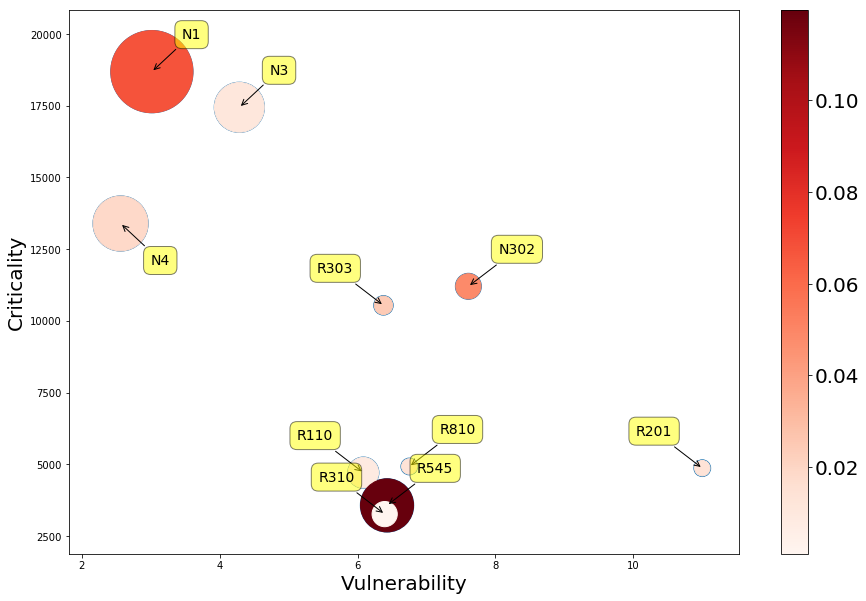

In [14]:
labels = roadTop.roadName
colors = roadTop.heavy_truck_frac#/(roadTop.TruckFrac.max())

size  = []
size2 = []
for t in roadTop.nrBridges.values:
    size.append(math.sqrt(t)*240)
    size2.append(math.sqrt(t)*240 + 40)
# define colormap

# set figure size
fig = plt.figure(figsize=(15,10))

ax1 = plt.scatter(roadTop['bridgeScore'],roadTop['maxAADT'], s=size2)
ax  = plt.scatter(roadTop['bridgeScore'],roadTop['maxAADT'], s=size, c=colors, cmap=plt.cm.Reds)
                                 #roadTop.total/25)


for label, x, y in zip(labels, roadTop['bridgeScore'], roadTop['maxAADT']):
    if label=='R110' or label=='R310' or label=='R201' or label=='R303':
        plt.annotate(
            label,
            xy=(x, y), xytext=(-30, 30), size=14,
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    elif label=='N4':
        plt.annotate(
            label,
            xy=(x, y), xytext=(30, -30), size=14,
            textcoords='offset points', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    else:
        plt.annotate(
            label,
            xy=(x, y), xytext=(30, 30), size=14,
            textcoords='offset points', ha='left', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

# set labels
plt.xlabel('Vulnerability', fontsize=20)
plt.ylabel('Criticality', fontsize=20)

# change ticksize
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

# set colorbar
cbar = fig.colorbar(ax)
plt.show()

## Plot the map of those "N" roads to check the detailed segmentation

In [15]:
rname = roadTop['roadName'].values.tolist()

# General function to get the plot of the map and combined dataframe for 4 dataframe
mymap2, df2_universal  = function1(rname,road_path,bridge_path,path)

# Save the map into html format called results that saved in the working directory
mymap2.save('results_top.html') 

# Open new tab automatically for the html output that produced
webbrowser.open('results_top.html')

True